FileName = ImgSegmentation_U-Net_Inception.ipynb. The code here shows how to use the U-Net Architecture for Semantic Img Segmentation using TF/Keras  

The dataset used comes from he Oxford IIT Pets data set. The code is located at

    /drv3/hm3/code/python/keras.3.02/

The original code was running in a Virtual Env under Python 3.10.12, with TF/Keras 2.15
The data is supposed to be obtain as

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

But instead I visited Kaggle, obtained the dataset and stored it at 

/dev3/hm3/Data/ImgData/Oxford_iit_pets

As of Feb 2025, the code is running under TF/Keras 2.18


In [1]:
# get the libraries ready
import os
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np

import shutil, pathlib

import matplotlib.image as mpimg
from PIL import Image 
from PIL import ImageOps

# APIs to plot a keras model using keras.utils.plot_model()
# besides installing graphviz via pip install graphviz,
# I also had to install in Ubuntu via sudo apt install graphviz 
import pydot
import graphviz


import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

import keras
from keras import layers
from keras.utils import load_img, img_to_array
from keras.utils import array_to_img

print("pydot version    = ", pydot.__version__)
print("graphviz version = ", graphviz.__version__)
print(tf.__version__)
print(keras.__version__)
print(matplotlib.__version__)
print( tf.config.list_physical_devices('GPU') )

2025-02-22 02:45:28.391931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740192328.405542       9 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740192328.409412       9 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 02:45:28.424581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


pydot version    =  3.0.4
graphviz version =  0.20.3
2.18.0
3.8.0
3.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
base_dat_dir = "./imgSegExcercise/Oxford_iiit_pets/"

input_dir  = base_dat_dir + "images/"   # contains the 7,394 images
target_dir = base_dat_dir +  "annotations/trimaps/"

# there are 7390 files in input_img_paths
input_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

# there are 7390 files in target_img_paths
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

img_size = (160, 160)
num_classes = 3
batch_size = 32


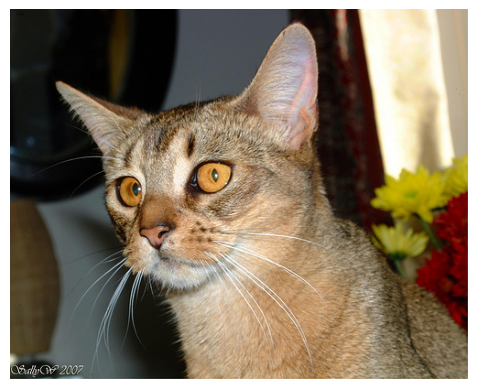

In [3]:
# image displayed is "Abyssinian_107.jpg" Image is of size 151 KBs
plt.axis("off")
plt.imshow(load_img(input_paths[10]))

In [ ]:
def cleanFullSetData( dataDir):
    for image in sorted(glob.glob(dataDir)):
        try:
            # print(image)
            imgName = str(image)
            img = read_file( imgName )
            # img = decode_image(img)
            d_img = tf.image.decode_jpeg( img )
            # print( imgName )
            if d_img.shape[2] != 3:
                # os.remove(image)
                imgName.unlink()
                os.remove( imgName )
        except Exception as e:
            print(" bad file: ", imgName)

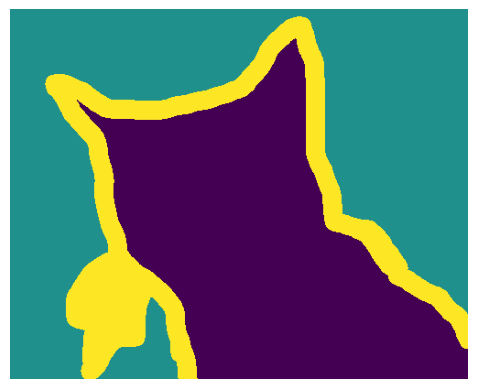

In [4]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[10], color_mode="grayscale"))
display_target(img)

In [5]:
""" 
The images in the dataset have different shapes and sizes.
Images and mask must be of the same shape (size).
Returns a TF Dataset, which consists of a tuple with ( inputFiles, TargetFiles) 
The function is used to create the dataset for train and for validation   
"""
def get_dataset( batch_size, img_size, input_img_paths, target_img_paths, max_dataset_len=None) :

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_paths = input_paths[:max_dataset_len]
        target_paths = target_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


# Split our img paths into training and validation sets
val_samples = 1000
random.Random(1337).shuffle(input_paths)
random.Random(1337).shuffle(target_paths)

train_input_paths = input_paths[:-val_samples]
train_target_paths = target_paths[:-val_samples]

val_input_paths = input_paths[-val_samples:]
val_target_paths = target_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(batch_size, img_size, train_input_paths, train_target_paths,
    # max_dataset_len=1000,
)
val_dataset = get_dataset( batch_size, img_size, val_input_paths, val_target_paths)


I0000 00:00:1740192337.971338       9 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


target img shape =  (500, 375)
np shape =  (187500,)
np2_frame.shape =  (187500,)
input img shape =  (500, 375, 3)
np shape =  (187500, 3)
np2_frame.shape =  (187500, 3)


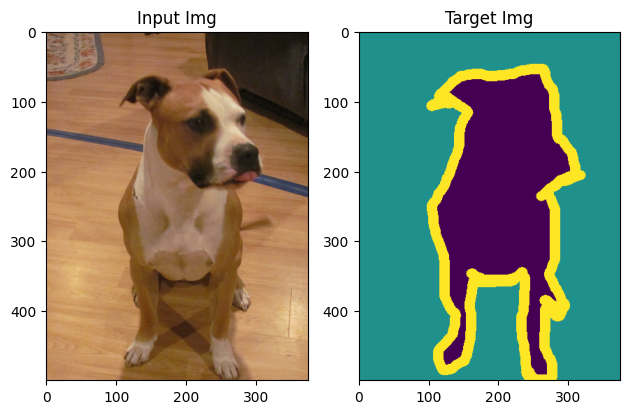

In [6]:
# verify data is ready

i=10

target_img_file = train_target_paths[i]  
target_img = mpimg.imread( target_img_file)
print("target img shape = " , target_img.shape )

target_im_frame = Image.open( target_img_file)
np_frame = np.array( target_im_frame.getdata())
print("np shape = ", np_frame.shape)
np2_frame = np.reshape( np_frame, np_frame.shape) 
print("np2_frame.shape = ", np2_frame.shape )
#plt.imshow( target_img )

input_img_file = train_input_paths[i]  
input_img = mpimg.imread( input_img_file)
print("input img shape = " , input_img.shape )

input_im_frame = Image.open( input_img_file)
np_frame = np.array( input_im_frame.getdata())
print("np shape = ", np_frame.shape)
np2_frame = np.reshape( np_frame, np_frame.shape) 
print("np2_frame.shape = ", np2_frame.shape )
#plt.imshow(input_img )

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2)
  
# Plot input Img 
axis[0].imshow(input_img)
axis[0].set_title("Input Img")
  
# For target Img 
axis[1].imshow(target_img)
axis[1].set_title("Target Img")

# Combine imgs in a tight layout  
plt.tight_layout() 
plt.show()



In [7]:
# define the u-net-inception 

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()
# keras.utils.plot_model( model, to_file="/drv3/hm3/code/python/keras.3.02/u-net-inception-model.png" )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [8]:
# process data with the u-net-inception model  

model.compile(optimizer=tf.keras.optimizers.Adam( 1e-4), loss="sparse_categorical_crossentropy",
                #   metrics="accuracy") #Error de paquete inicial
                  metrics=['accuracy'])

num_epochs = 20

callback_dir = "./imgSegExcercise/Playground/oxford_pets_segmentation_02_U-net.keras"

callbacks = [ keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True) ]

history = model.fit(train_dataset, validation_data= val_dataset, verbose=0, epochs=20, batch_size=32)


I0000 00:00:1740192369.102325      74 service.cc:148] XLA service 0x79a844002f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740192369.102398      74 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-22 02:46:09.421258: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1740192369.843406      74 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1740192370.358857      74 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-22 02:46:27.852296: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, X

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:
# val_dataset is already created

"""
To visualize the predictions that the model makes, do the following:

1. Use keras.models.load_model( callbackdir ) to get the model's params

2. Select target imgs from val_dataset (those imgs have not been seen by the model before).

3. Several variables are used to keep track of where things are:

    it is a list of .jpg file names
    it is a list of PIL images
    it is a list of np.array objs, which were converted from the PIL images
 
    pil image
    np.array

3. The input files are .jpg files which can be can be displayed directly with code like
   test_image = val_input_paths[i]
   plt.imshow(load_img(test_image))

4. To do prediction call Model.predict(x, batch_size=None, verbose="auto", steps=None, callbacks=None)
    X could be (1) np.array, (2) list of np.arrays, (3) Tensor, (4) List of Tensors, 
    (5) tf.data.Dataset, (6) keras.utils.Pydataset
5. If type(X) == np.array , X must be converted from PIL to an np.array, using somethihg like this:

    val_target_file = train_target_paths[0]  
    val_target_img = mpimg.imread( val_target_file)
    print("val target img shape = " , val_target_img.shape )

    target_im_frame = Image.open( target_img_file)
    np_frame = np.array( target_im_frame.getdata())
    print("np shape = ", np_frame.shape)
    np2_frame = np.reshape( np_frame, np_frame.shape) 
    print("np2_frame.shape = ", np2_frame.shape )
    


"""

# model = keras.models.load_model(callbacks)
model = keras.models.load_model(callback_dir)

val_preds = model.predict(val_dataset) # Shape is (1000, 160, 160, 3)
print("val_preds.shape =", val_preds.shape)

print("val_preds[1].shape =", val_preds[1].shape)


# img to validate
i = 10

test_image = val_input_paths[i]
plt.imshow(load_img(test_image))

val_target_file = val_target_paths[0]  
val_target_img = mpimg.imread( val_target_file )
print("val target img shape = " , val_target_img.shape )

target_im_frame = Image.open( val_target_file)
np_frame = np.array( target_im_frame.getdata())
print("np shape = ", np_frame.shape)
np2_frame = np.reshape( np_frame, np_frame.shape) 
print("np2_frame.shape = ", np2_frame.shape )

# mask = model.predict( np.expand_dims(val_target_img[i],0 ))
# mask = model.predict( np_frame )     
# mask = model.predict(np2_frame)
mask = model.predict(np.expand_dims(test_image, 0))[0]


# plt.imshow(array_to_img(test_image))

# mpimg.imread( test_image)

# mask = model.predict(np.expand_dims(test_image, 0))[0]

# Display results for validation image #10


# Initialise the subplot function using number of rows and columns
#figure, axis = plt.subplots(1, 3)

#val_input_file = val_input_paths[i]  
#plt.imshow(test_image)
# plt.imshow(array_to_img(test_image))

#val_input_img = mpimg.imread( val_input_file)

# Plot input Img 
#axis[0].imshow(val_input_img)
#axis[0].set_title("Val Img")

#val_target_file = val_target_paths[i]
#val_target_img = mpimg.imread( val_target_file)
#axis[1].imshow(val_target_img)
#axis[1].set_title("Val Mask ")

#val_target_file = val_target_paths[i]
#val_target_img = mpimg.imread( val_target_file)
#axis[2].imshow(val_target_img)
#axis[2].set_title("Predicted Mask ")


# For target Img 
#axis[1].imshow(target_img)
#axis[1].set_title("Target Img")c

# Combine imgs in a tight layout  
#plt.tight_layout() 
#plt.show()

"""
model = keras.models.load_model(callback_dir)

i = 4
test_image = val_input_imgs[i]
plt.axis("off")c
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

   """



In [ ]:
# val_dataset already created. N oite the args to the call 
# val_dataset = get_dataset( batch_size, img_size, val_input_paths, val_target_paths)

val_dataset = get_dataset(
    batch_size, img_size, val_input_paths, val_target_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display target image
lofas_img = mpimg.imread( val_target_paths[i] )
plt.imshow(lofas_img)

# Display target image
lofas_img = mpimg.imread( val_input_paths[i] )
plt.imshow(lofas_img)


